# Text Mining Project 1

In [ ]:
%pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.9 MB

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
clickbait_df = pd.read_csv('./clickbait.csv')

clickbait_df

,Unnamed: 0,text,label
0,0,"Eva Hassett, VP of Savarino Construction Servi...",0
1,1,Kylie Jenner Told Ellen DeGeneres She's Proud ...,1
2,2,Australian rules football: 2010 Gippsland Foot...,0
3,3,Supercross: Stewart wins 4th consecutive Monst...,0
4,4,Wikinews interviews Prince Christopher I of th...,0
...,...,...,...
495,495,"Seth Rogen, Joseph Gordon-Levitt, And Anthony ...",1
496,496,Ruby Rose And Nina Dobrev Are Slated To Join D...,1
497,497,Koizumi has dissolved the Japanese Diet in res...,0
498,498,I Tweeted That Ariana And Frankie Grande Were ...,1


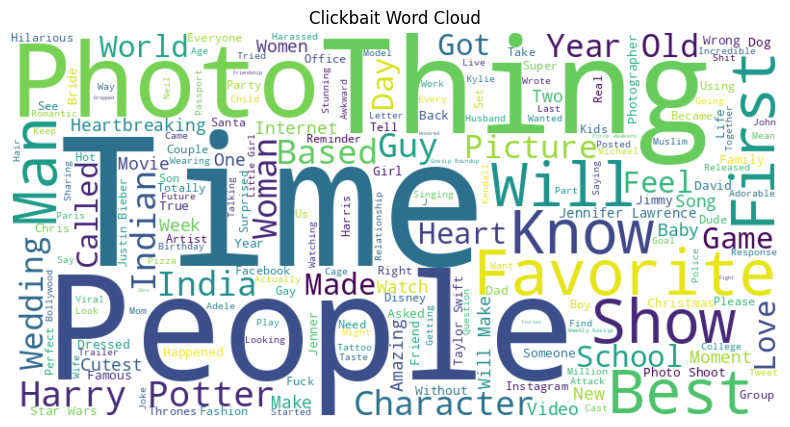

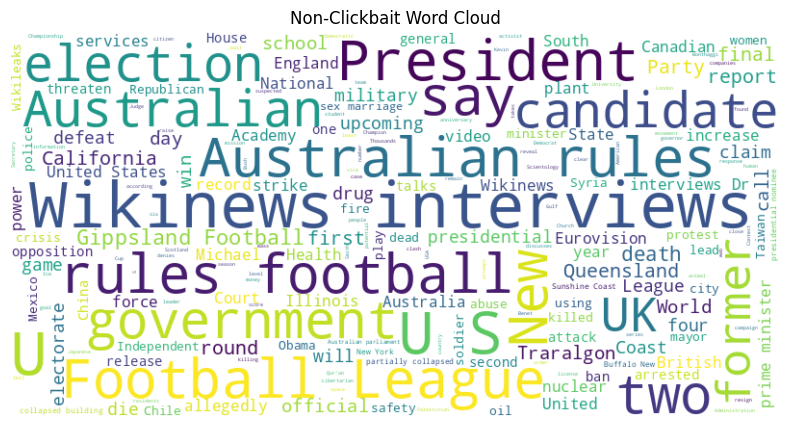

In [ ]:
clickbait_titles = clickbait_df[clickbait_df['label'] == 1]['text']
non_clickbait_titles = clickbait_df[clickbait_df['label'] == 0]['text']

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

clickbait_text = ' '.join(clickbait_titles)
generate_word_cloud(clickbait_text, 'Clickbait Word Cloud')

non_clickbait_text = ' '.join(non_clickbait_titles)
generate_word_cloud(non_clickbait_text, 'Non-Clickbait Word Cloud')

## Data preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

X_raw = clickbait_df['text']
y_raw = clickbait_df['label']

stop_words = set(stopwords.words('english'))

X_processed = X_raw.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words]))

lemmatizer = WordNetLemmatizer()
X_processed_l = X_processed.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

stemmer = PorterStemmer()
X_processed_r = X_processed.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

X_processed_lr = X_processed.apply(lambda x: ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in x.split()]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Bag-of-words preprocessing

In [ ]:
def vectorize_and_cross_validation(X, y, model, preprocessings):
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(X)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }
    cv_results = cross_validate(model, X_bow, y, cv=5, scoring=scoring, return_train_score=False)
    avg_metrics = {metric: round(np.mean(cv_results[f'test_{metric}']), 4) for metric in scoring}
    avg_metrics['preprocessings'] = preprocessings

    return avg_metrics

def build_and_test_model(model):
  avg_metrics_raw = vectorize_and_cross_validation(X_raw, y_raw, model, 'Nothing')
  avg_metrics = vectorize_and_cross_validation(X_processed, y_raw, model, 'Lowercase & Stopword removing')
  avg_metrics_l = vectorize_and_cross_validation(X_processed_l, y_raw, model, 'Lemmatization & Lowercase & Stopword removing')
  avg_metrics_r = vectorize_and_cross_validation(X_processed_r, y_raw, model, 'Stemming & Lowercase & Stopword removing')
  avg_metrics_lr = vectorize_and_cross_validation(X_processed_lr, y_raw, model, 'Lemmatization & Stemming & Lowercase & Stopword removing')

  all_avg_metrics = [avg_metrics_raw, avg_metrics, avg_metrics_l, avg_metrics_r, avg_metrics_lr]

  metrics = pd.DataFrame([avg_metrics_raw, avg_metrics, avg_metrics_l, avg_metrics_r, avg_metrics_lr])

  print(f"{model.__class__.__name__}:\n", metrics)
  print()
  print('-' * 52)
  print()

  return metrics

mnb_metrics = build_and_test_model(MultinomialNB())
svc_metrics = build_and_test_model(SVC())
lr_metrics = build_and_test_model(LogisticRegression())

MultinomialNB:
    accuracy  precision  recall  f1_score  \
0     0.950     0.9192   0.988    0.9522   
1     0.940     0.9207   0.964    0.9415   
2     0.936     0.9229   0.952    0.9371   
3     0.922     0.9025   0.948    0.9243   
4     0.922     0.9021   0.948    0.9242   

                                      preprocessings  
0                                            Nothing  
1                      Lowercase & Stopword removing  
2      Lemmatization & Lowercase & Stopword removing  
3           Stemming & Lowercase & Stopword removing  
4  Lemmatization & Stemming & Lowercase & Stopwor...  

----------------------------------------------------

SVC:
    accuracy  precision  recall  f1_score  \
0     0.930     0.9545   0.904    0.9277   
1     0.872     0.8482   0.908    0.8767   
2     0.890     0.8664   0.924    0.8939   
3     0.886     0.8760   0.900    0.8875   
4     0.898     0.8910   0.908    0.8990   

                                      preprocessings  
0       

## Transformer models

In [ ]:
def cross_validate_and_average(model_type, model_name, data, num_folds=5, num_train_epochs=1):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    results = []

    for fold, (train_index, test_index) in enumerate(skf.split(data['text'], data['labels'])):
        train_data, eval_data = data.iloc[train_index], data.iloc[test_index]
        output_dir = f'outputs_fold_{fold}/'

        model_args = ClassificationArgs(
            num_train_epochs=num_train_epochs,
            output_dir=output_dir,
            overwrite_output_dir=True
        )
        model = ClassificationModel(
            model_type,
            model_name,
            args=model_args
        )

        model.train_model(train_data)

        result, _, _ = model.eval_model(eval_data)
        result['fold_nr'] = fold + 1

        results.append(result)

    return pd.DataFrame(results)

data = pd.DataFrame({'text': X_raw, 'labels': y_raw})
models = [
    {
        'type': 'bert',
        'name': 'bert-base-cased',
    },
    {
        'type': 'distilbert',
        'name': 'distilbert-base-cased',
    },
    {
        'type': 'roberta',
        'name': 'roberta-base',
    },
]

model_results = {}

for model in models:
  model_results[model['type']] = cross_validate_and_average(model['type'], model['name'], data)

model_results

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

{'bert':    mcc  tp  tn  fp  fn  auroc  auprc  eval_loss  fold_nr
 0  1.0  50  50   0   0    1.0    1.0   0.010210        1
 1  1.0  50  50   0   0    1.0    1.0   0.005787        2
 2  1.0  50  50   0   0    1.0    1.0   0.002009        3
 3  1.0  50  50   0   0    1.0    1.0   0.012638        4
 4  1.0  50  50   0   0    1.0    1.0   0.009347        5,
 'distilbert':         mcc  tp  tn  fp  fn  auroc  auprc  eval_loss  fold_nr
 0  1.000000  50  50   0   0    1.0    1.0   0.014166        1
 1  1.000000  50  50   0   0    1.0    1.0   0.006839        2
 2  1.000000  50  50   0   0    1.0    1.0   0.006030        3
 3  1.000000  50  50   0   0    1.0    1.0   0.007199        4
 4  0.980196  49  50   0   1    1.0    1.0   0.027378        5,
 'roberta':         mcc  tp  tn  fp  fn   auroc     auprc  eval_loss  fold_nr
 0  1.000000  50  50   0   0  1.0000  1.000000   0.000748        1
 1  0.980196  50  49   1   0  1.0000  1.000000   0.065563        2
 2  1.000000  50  50   0   0  1.0000  

In [ ]:
def calculate_metrics(model_results):
    metrics_summary = []

    for model_name, results_df in model_results.items():
        sum_results = results_df.sum()

        tp = int(sum_results['tp'])
        tn = int(sum_results['tn'])
        fp = int(sum_results['fp'])
        fn = int(sum_results['fn'])

        y_true = np.concatenate([np.ones(tp + fn), np.zeros(tn + fp)])
        y_pred = np.concatenate([np.ones(tp + fp), np.zeros(tn + fn)])

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        metrics_summary.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'model': model_name,
        })

    return metrics_summary

transformer_results = pd.DataFrame(calculate_metrics(model_results))

print(transformer_results)

   accuracy  precision  recall  f1_score       model
0     1.000        1.0   1.000  1.000000        bert
1     0.998        1.0   0.996  0.997996  distilbert
2     1.000        1.0   1.000  1.000000     roberta


<ipython-input-9-02418740f34c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_accuracies))


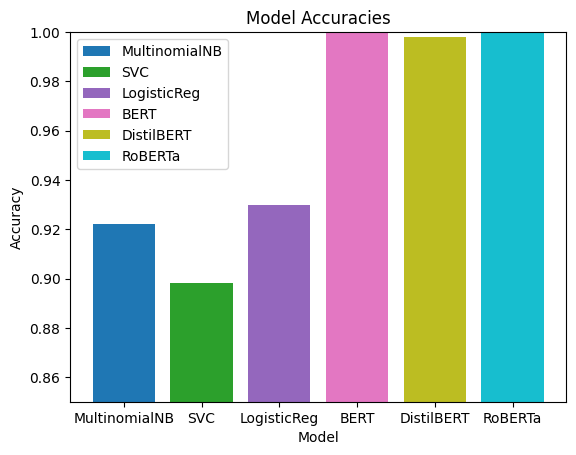

In [ ]:
def plot_model_accuracies(model_accuracies):
    model_names = [model['name'] for model in model_accuracies]
    accuracies = [model['accuracy'] for model in model_accuracies]

    fig, ax = plt.subplots()

    colors = plt.cm.get_cmap('tab10', len(model_accuracies))

    bars = ax.bar(model_names, accuracies, color=colors(np.arange(len(model_accuracies))))

    ax.set_ylim(0.85, 1)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model')
    ax.set_title('Model Accuracies')

    ax.legend(bars, model_names)

    plt.show()

model_accuracies = [
    {'name': 'MultinomialNB', 'accuracy': mnb_metrics.iloc[4]['accuracy']},
    {'name': 'SVC', 'accuracy': svc_metrics.iloc[4]['accuracy']},
    {'name': 'LogisticReg', 'accuracy': lr_metrics.iloc[4]['accuracy']},
    {'name': 'BERT', 'accuracy': transformer_results.iloc[0]['accuracy']},
    {'name': 'DistilBERT', 'accuracy': transformer_results.iloc[1]['accuracy']},
    {'name': 'RoBERTa', 'accuracy': transformer_results.iloc[2]['accuracy']},
]

plot_model_accuracies(model_accuracies)

In [ ]:
import pandas
import wordcloud
import matplotlib
import nltk
import numpy
import sklearn

print('Package versions:')
print('pandas - ', pandas.__version__)
print('wordcloud - ', wordcloud.__version__)
print('matplotlib - ', matplotlib.__version__)
print('nltk - ', nltk.__version__)
print('numpy - ', numpy.__version__)
print('sklearn - ', sklearn.__version__)
print('simpletransformers - 0.64.3')

Package versions:
pandas -  1.5.3
wordcloud -  1.9.3
matplotlib -  3.7.1
nltk -  3.8.1
numpy -  1.23.5
sklearn -  1.2.2
simpletransformers - 0.64.3
